# Training a classifier on a real dataset.

## Task:
We need to train a classifier that determines the type of bicycle on a small dataset of bicycle photos from public sources.

Analyze the data and select the appropriate tools and metrics to address this challenge.

You may use pre-trained models from torchvision.models.
Write a report on the results.

# Data

In [1]:
#!wget http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip

In [2]:
#!unzip bt_dataset3.zip

# Solution

In [3]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import cv2
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.functional import accuracy
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.transforms import v2
from torchmetrics.classification import MulticlassAccuracy, MulticlassAUROC, MulticlassAveragePrecision, \
    MulticlassF1Score
import wandb

from torchinfo import summary

from torchvision.models import convnext_base, ConvNeXt_Base_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Посчитаю среднее и диспервию для датасета
# train_dataset = ImageFolder('bike/bike_type/train', transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.Resize((224, 224))]))
# train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
# img, _ = next(iter(train_dataloader))
# print(img.mean([0, 2, 3]).tolist())
# print(img.std([0, 2, 3]).tolist())

# [0.4168095588684082, 0.402756005525589, 0.4077109396457672]
# [0.20375357568264008, 0.19675317406654358, 0.19723662734031677]

### Предобработка + аугментации

In [5]:
train_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize((224, 224)),
        v2.RandomApply([v2.RandomRotation(degrees=15)], p=0.25),
        v2.RandomApply([v2.ColorJitter(brightness=0.05, hue=0.05)], p=0.5),
        v2.RandomApply([v2.RandomEqualize()], p=0.25),
        v2.RandomPerspective(distortion_scale=0.2, p=0.25),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.4168095588684082, 0.402756005525589, 0.4077109396457672],
                     std=[0.20375357568264008, 0.19675317406654358, 0.19723662734031677])
    ]
)
val_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.4168095588684082, 0.402756005525589, 0.4077109396457672],
                     std=[0.20375357568264008, 0.19675317406654358, 0.19723662734031677])
    ]
)
train_dataset = ImageFolder('bike/bike_type/train', transform=train_transform)
val_dataset = ImageFolder('bike/bike_type/val', transform=val_transform)

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=6, persistent_workers=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, num_workers=6, persistent_workers=True)

### Посмотрю на данные

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


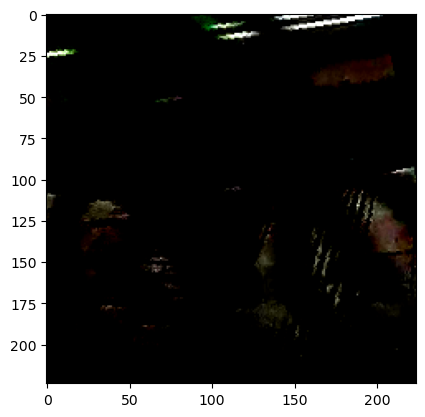

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


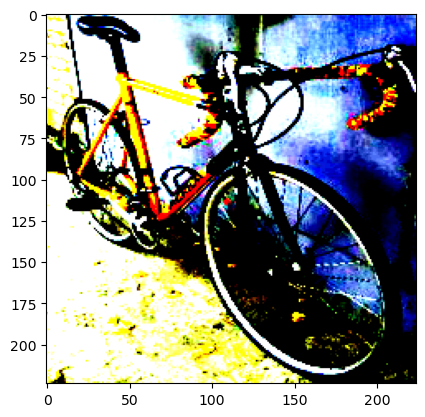

In [6]:
# аугментированные и нормализованные данные
for batch in train_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


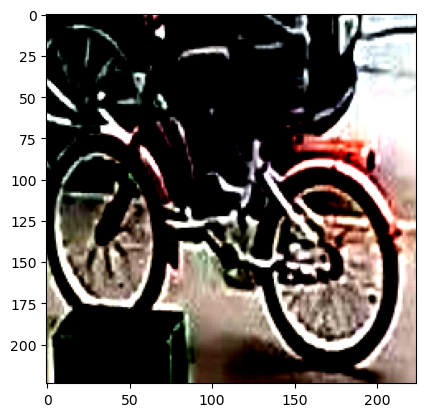

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


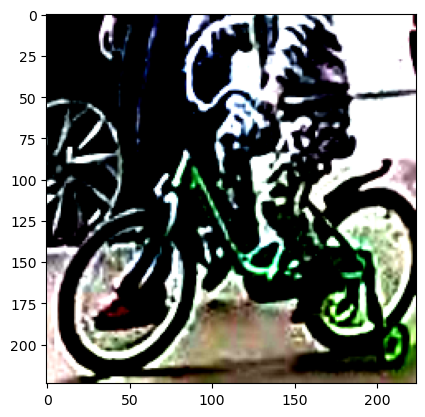

In [7]:
# нормализованные
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

Баланс классов

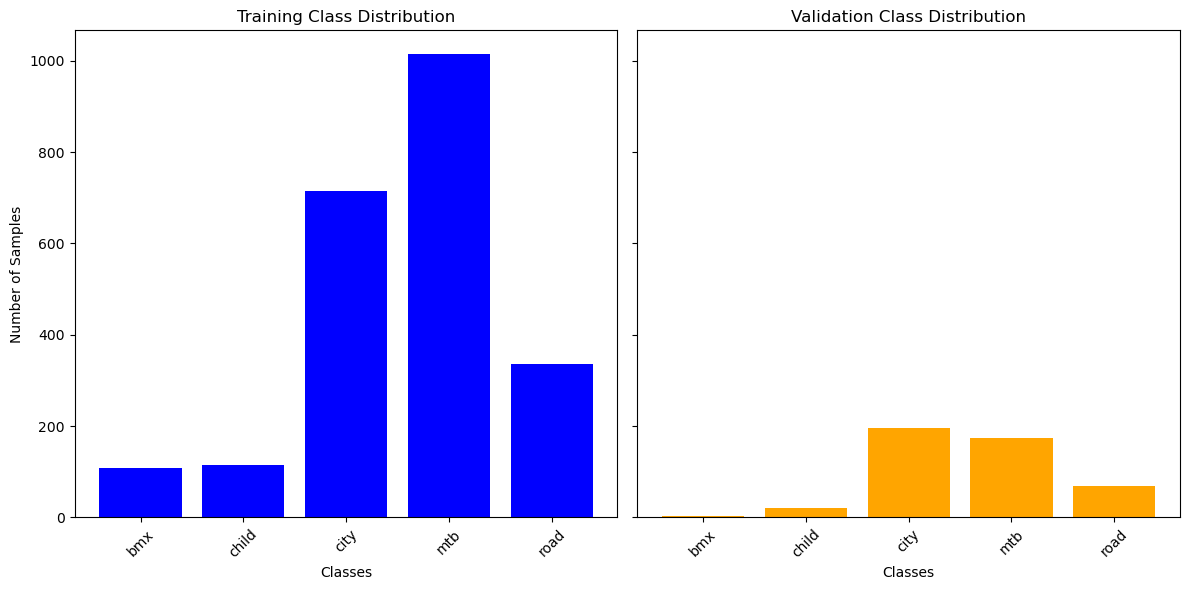

In [8]:
from collections import Counter

train_class_counts = Counter(train_dataset.targets)
val_class_counts = Counter(val_dataset.targets)

class_names = train_dataset.classes

train_class_distribution = {class_names[i]: train_class_counts[i] for i in range(len(class_names))}
val_class_distribution = {class_names[i]: val_class_counts[i] for i in range(len(class_names))}

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].bar(train_class_distribution.keys(), train_class_distribution.values(), color='blue')
axes[0].set_title("Training Class Distribution")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Number of Samples")
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(val_class_distribution.keys(), val_class_distribution.values(), color='orange')
axes[1].set_title("Validation Class Distribution")
axes[1].set_xlabel("Classes")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Классы несбалансированные:
- добавлю веса для лосса
- добавлю f1 score в качестве метрики, более устойчивой к дисбалансу классов
- Для аккураси буду использовать макроусреднение, чтобы у всех классов была одинаковая важность

### Модель
Попробую сделать transfer learning с ConvNext base

In [9]:
trained_model = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)

In [10]:
trained_model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

Заморожу веса и поменяю слой классификатора на более сложный

In [11]:
for param in trained_model.parameters():
    param.requires_grad = False

In [12]:
trained_model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024,
              out_features=1000, bias=True),
    nn.BatchNorm1d(1000, eps=0.001, momentum=0.1, affine=True),
    nn.SiLU(inplace=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1000,
              out_features=100, bias=True),
    nn.BatchNorm1d(100, eps=0.001, momentum=0.1, affine=True),
    nn.SiLU(inplace=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=100,
              out_features=5, bias=True),
)

In [13]:
summary(model=trained_model,
        input_size=(1, 3, 224, 224),  #[batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [1, 3, 224, 224]     [1, 5]               --                   Partial
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 1024, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [1, 3, 224, 224]     [1, 128, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 128, 56, 56]     (6,272)              False
│    │    └─LayerNorm2d (1)                             [1, 128, 56, 56]     [1, 128, 56, 56]     (256)                False
│    └─Sequential (1)                                   [1, 128, 56, 56]     [1, 128, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [1, 128, 56, 56]     [1, 128, 56, 56]     (138,496)            

### Обучение
Буду обучать с использованием pytorch lighting, оптимайзером AdamW без шедулера. Собирать метрики буду в wandb с сохранением лучших весов по f1 score

In [14]:
class MyModule(pl.LightningModule):
    def __init__(self, m, learning_rate, loss):
        super().__init__()
        self.model = m
        self.learning_rate = learning_rate
        self.loss = loss

        self.val_accuracy = MulticlassAccuracy(num_classes=5, average="macro")
        self.val_f1 = MulticlassF1Score(num_classes=5, average="weighted")

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        predictions = self.forward(images)
        loss = self.loss(predictions, target)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        predictions = self.forward(images)

        loss = self.loss(predictions, target)
        
        probabilities = torch.nn.functional.softmax(predictions, dim=-1)

        acc = self.val_accuracy(torch.argmax(predictions, dim=-1).long(), target.long())
        f1 = self.val_f1(torch.argmax(predictions, dim=-1).long(), target.long())

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", acc, prog_bar=True, logger=True)
        self.log("val_f1", f1, prog_bar=True, logger=True)
        return loss

wandb

In [15]:
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [16]:
run = wandb.init(project="hse-cv-hw3")

In [17]:
wandb_logger = WandbLogger(
    log_model='all',
    name='ConvNext_50_epoch_weighted'
)

обучение

In [18]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_dataset.targets),
                                                  y=train_dataset.targets)
loss = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32))

In [19]:
module = MyModule(trained_model, 0.001, loss)

In [20]:
EPOCHS = 60

In [21]:
checkpoint_callback_trainable = pl.callbacks.ModelCheckpoint(dirpath="best_weight_transfer",
                                                             save_top_k=2,
                                                             monitor="val_f1",
                                                             mode="max")

In [22]:
torch.use_deterministic_algorithms(False)

trainer = pl.Trainer(logger=wandb_logger,
                     max_epochs=EPOCHS,
                     accelerator=device,
                     callbacks=[checkpoint_callback_trainable],
                     log_every_n_steps=10
)
trainer.fit(module, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Programs\anaconda\envs\dl\Lib\site-packages\pytorch_lightning\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
C:\Programs\anaconda\envs\dl\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory D:\HSE\Course3\CV\hw3\best_weight_transfer exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | ConvNeXt           | 88.7 M | train
1 | loss         | CrossEntropyLoss   | 0      | train
2 | val_accuracy | MulticlassAccuracy | 0      | train
3 | val_f1       | MulticlassF1Score  | 0      | train
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


### Валидация

In [31]:
checkpoint_path = "best_weight_transfer/epoch=49-step=1800.ckpt"

validation = trainer.validate(module, val_dataloader, ckpt_path=checkpoint_path)

Restoring states from the checkpoint path at best_weight_transfer/epoch=49-step=1800.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at best_weight_transfer/epoch=49-step=1800.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy          0.39481350779533386
         val_f1             0.9032041430473328
        val_loss            0.6014401316642761
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
wandb.finish()

# Report
Обучил ConvNeXt_Base_Weights на 88 миллионов параметров
Использовал оптимайзер Adamw и немного аугментаций

На 70 итерациях максимальное accuracy = 0.8633 (на 37 эпохе на валидации)
Но эти значения были получены без взвешенных весов и макроусреднения

Затем я посмотрел баланс классов, после чего добавил веса в лосс и f1 метрику для несбалансированных классов

Здесь результаты получились хуже, но более реальными. Я оптимизировал f1 score.
Модель, скорее всего начала правильно меньшинственные классы целой красивых метрик.
В остальном модель была такой же. Лучшие значения получилось выбить на 49-й эпохе
Итоговый f1 score: 0.9
accuracy: 0.39

Для сбора метрик использовал Wandb. Для второго теста сделал отдельные таблицы, так как метрики отличаются.
По какой-то причине эксперименты переставали трекаться после шестой эпохи, видимо слишком долго загружаются.
Перезапускать эксперименты не очень хочется, к тому же качество на 6 эпохе уже удовлетворительное
Report: https://api.wandb.ai/links/vldmrl-org/x46fa06v
 